# Get required functions for getting data

In [1]:
import os
os.chdir('/home/tzd/fs03/d1/tzd/Data_analysis/RAworkflow')
%run ./My_Modules/DataSetUP10VAR.ipynb

boxes().shape[0]
# getNoASGM():       => Hg0no_ASGM dataframe; in correct units
# get_model(region): => Hg0_modified; in correct units (takes gridbox region in Peru as input)
# getLoRes():        => Hg0 baseline with ASGM low resulution in correct units
# getHiRes():        => Hg0 baseline with ASGM high resulution in correct units
# getNoASGM():       => Hg0 baseline without ASGM low resulution in correct units
# get_obs_d():       => obs_Hg0; original observations daily mean values
# get_detrended_obs(): => Obs_detrended; return detrended observations
# get_detrended_model(model): => This function takes in a dataframe of model outputs 
                                and returns the detrended version of that model output
# getObsIQR(obs): This function takes observations and returns the IQR 
# getIQR_Dd(model): This function takes in a dataframe of model outputs and returns the detrended IQR
# getIQR(model): => This function takes in a dataframe of model outputs and returns the IQR
#

/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.stats import norm,iqr,bootstrap
import warnings
warnings.filterwarnings('ignore')

# Formular for Calculating Emission Signal from each gridbox

$$\small{Y_{signal}} =\small\frac{(X_{modified}-X_{base})}{(M_1-M_0)}\small{(M-M_o)}$$

* $\small{Y_{signal}}$ : The Emission signal from a gridbox

* $X_{modified}$ : The modified emissions GEOS Chem output __(model output)__
* $X_{base}$ : The baseline emissions GEOS Chem output __(model output)__
* $M_1$ : The Hg mass after modification __(known)__
* $M_0$ : The Hg mass before modification __(known)__
* $M$ : The intended Hg emissions mass __(unknown)__

The above equation can be expanded in to separate the uknowns from the known information so that $M$ can be used as a parameter in our optimization

$$\small{Y_{signal}} =\small\frac{(X_{modified}-X_{base})}{(M_1-M_0)}M-\small\frac{(X_{modified}-X_{base})}{(M_1-M_0)}M_o$$

let $$W_{region}=\small\frac{(X_{modified}-X_{base})}{(M_1-M_0)}$$

hence the above equation becomes:
$$\small{Y_{signal}} =W_{region}M-W_{region}M_o$$

## Optimization of combined signal from differnt gridboxes 

The modified model output at Chalcataya accounting for signals from the different regions is given by the equation: 

$$Hg_{(modified)}= HgSignal_{(MdD )}+ HgSignal_{(S-Puno)} + HgSignal_{(N-Puno)}+ HgSignal_{(Apurimac)}+ HgSignal_{(Arequipa)}+HgBaseline_{(No-ASGM)}$$

$$Hg_{(modified)}= (W_{(MdD)}M-W_{(MdD)}M_o)+ (W_{(S-Puno)}M-W_{(S-Puno)}M_o) + (W_{(N-Puno)}M-W_{(N-Puno)}M_o)+ (W_{(Apurimac)}M-W_{(Apurimac)}M_o)+  (W_{(Arequipa)}M-W_{(Arequipa)}M_o)+HgBaseline_{(No-ASGM)}$$

$M$  is the parameter that we want to modify hence let $θ=M$ and combine all the  $−𝑊_{(𝑀𝑑𝐷)}𝑀$  in to one constant  $Z$  which leads to the simplified equation:

$$Hg_{(modified)}= (HgBaseline_{(no-ASGM)}θ_0 + Z\theta_1 + W_{(mdd)}θ_2+ W_{(s-pun)}θ_3 + W_{(n-pun)}θ_4+ W_{(aprc)}θ_5+  W_{(aqpa)}θ_6$$



# Model Represenation:

$$Y = F(theta)+ E$$
$$Y=\begin{bmatrix} (Hg_{(no-ASGM base)}- Z) & W_{(s-pun)} \end{bmatrix} × \begin{bmatrix} \theta_0 \\θ_1 \end{bmatrix}$$ 

where $\theta_0 =1$ and $E=0$



# Initialize constant term and the required regions

In [3]:

def initEmcee(RefSiteNum,gbox):
    ConstantTerm=getConst(RefSiteNum,regions)
    region_sig=multiSiteSignal(gbox,RefSiteNum).to_numpy()
    return ConstantTerm,region_sig

# Model Function

In [4]:
def set_metric(metric_type):
    if metric_type=='95th':
        print("model metric is 95th percentile")
        def model(theta):
            
            modified=ConstantTerm+ region_sig*theta
            
            summary =pd.DataFrame(modified)
            model_out = list(summary.apply(find_95th))

            return model_out
    elif metric_type=='mean':
        print("model metric is mean")
        def model(theta):
            
            modified=ConstantTerm+ region_sig*theta 
            model_out = list(modified.mean(axis=0))

            return model_out
    else:
        print("model metric is IQR")
        def model(theta):
            modified=ConstantTerm+ region_sig*theta 
            model_out = list(iqr(modified, axis=0))

            return model_out
    return model

## Sanity Check

In [5]:

ConstantTerm,region_sig=initEmcee(0,'spun')
thet = [7.748216414]
model=set_metric('iqr')
model(thet)

model metric is IQR


[0.15101170410493103]

## Set up likelihood functions

In [6]:
def lnlike(theta, y_obs, y_err):
    """Calculating log likelihood assuming iid Gaussian errors
       Parameters
       ----------
       theta : parameters
       y_obs : observed value (e.g. of IQR)
       y_err : error in observed value (e.g. of IQR)

    """
    y = model(theta) # calculate modelled output
    # calculate log-likelihood that observed value is drawn from normal
    # distribution with mean y (modelled value) and sigma = y_err
    LnLike = norm.logpdf(y_obs, y, y_err)
    return LnLike

In [7]:
def lnprior(theta):
    """Apply prior assumption bounds (i.e. upper and lower bounds of variables)
       Parameters
       ----------
       theta : parameters    
    """
    
    E1 = theta
    
    # Prior assumptions for emissions - vary between 0 and 100 (can adjust this):
    min_emiss = 0
    max_emiss = 100
    
    if E1 <= min_emiss:#enforce lower bound
        return -np.inf
    elif E1 >= max_emiss:  #enforce upper bound
        return -np.inf
    else: # all values within prior bounds
        return 0.0
    

In [8]:
def lnprob(theta, y_obs, y_err):
    """Overall function that calculates log likelihood probability
       Parameters
       ----------
       theta : parameters  
       y_obs : observed value (e.g. of IQR)   
       y_err : error in observed value (e.g. of IQR)      
    """
    
    lp = lnprior(theta) #call lnprior
    if not np.isfinite(lp): # check if lp is non-zero:
        return -np.inf
    else: #recall if lp not -inf, its 0, so this just returns likelihood
        return lp + lnlike(theta, y_obs, y_err) 


# New Run

In [9]:
def fun_iqr(sample,axis): #function for calculating 95th percentile range
    result = np.quantile(sample, 0.75,axis) - np.quantile(sample, 0.25,axis) 
    return result

In [10]:
def fun_95th(sample,axis): #function for calculating iqr
    iqr = np.quantile(sample, 0.975,axis) - np.quantile(sample, 0.025,axis) 
    return iqr

In [11]:
def run_simulation(RefSiteNum,metric,init):
    
    
    #theta_true = (E1_true, E2_true, E3_true,E4_true, E5_true)
    if metric == '95th':
        y_true = fun_95th(obs_Hg0_d['value'],0)
        data = obs_Hg0_d['value'].to_numpy()
        res = bootstrap((data,), fun_95th)
        y_err = (np.array(res.standard_error)).mean()
        print(f"The true value of y is: {y_true} \n ")
        print(f"the error is: {y_err}")
    elif metric == 'mean':
        y_true = obs_Hg0_d['value'].mean()
        data = obs_Hg0_d['value'].to_numpy()
        res = bootstrap((data,), np.mean)
        y_err = (np.array(res.standard_error)).mean()
        print(f"The true value of y is: {y_true} \n")
        print(f"the error is: {y_err}")
    else:
        y_true = getObsIQR(obs_Hg0_d)
        data=obs_Hg0_d['value']
        res = bootstrap((data,), fun_iqr)
        y_err = (np.array(res.standard_error)).mean()

    initial = init

    ndim = len(initial)
    # hyperparameter for jump size between guesses
    step_size = 1e-5 
    # number of chains to run simultaneously and their length
    nwalkers = 100
    niter = 1000

    # setting initial guesses for all of the chains
    p0 = [np.array(initial) + step_size * np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(y_true, y_err))
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)
    return sampler

# Sanity check

In [12]:
data = obs_Hg0_d['value']
res = bootstrap((data,),  np.mean)
y_err = (np.array(res.standard_error)).mean()
grid_boxes=['spun','npun','mdd','aqp','apr']

region=grid_boxes[0]
init = np.array([scalors[region][0]]) #[7.75, 11.66, 50, 23.86, 10]
metrics=['mean','95th','iqr']
error=y_err
ref_sites=0
super_metric_dict={}
for metric in metrics:
     #select the model based on the metric being used
    model = set_metric(metric)
    # initialize the constant teerms based on the right model
    ConstantTerm,region_sig=initEmcee(ref_sites,region)
    #run MCMC simulation
    sampler=run_simulation(ref_sites,metric,init)
    super_metric_dict[metric]= sampler
    #create corner plot

ValueError: Percentiles must be in the range [0, 100]

## generate plots

**Plot Functions**

**Create Plots**

Mean


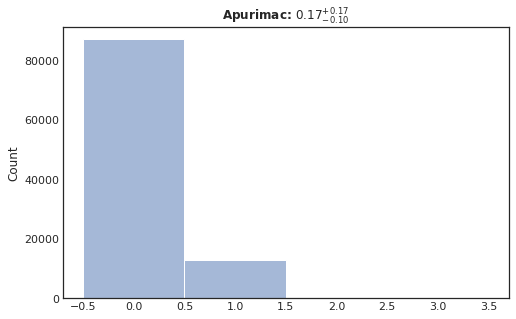

$95^{th}$ Percentile Range


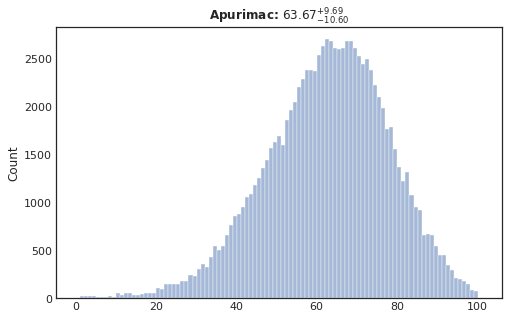

Interquartile Range


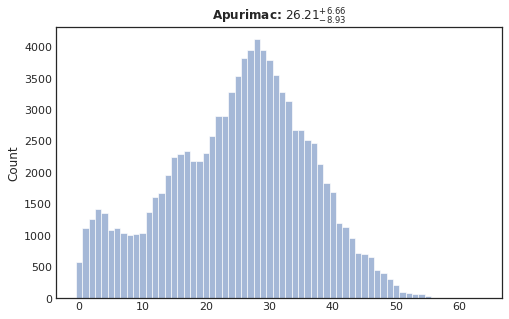

In [ ]:
for metric in metrics:
    if metric=='mean':
        met='Mean'
    elif metric=='95th':
        met= '$95^{th}$ Percentile Range'
    else:
        met= 'Interquartile Range'
    sampler=super_metric_dict[metric]
    #create corner plots
    corner_title= '''Corner'''+met
    print(met)
    plothist(sampler,region)
    #create boxplot 
    #box_title= '''Box Plot Showing Distribution of Emission Estimates
    #From Given Grid Boxes when the Metric is the '''+met 
    #df_metric['Puno']=df_metric['South Puno']+df_metric['North Puno']
    #plotBox(sampler,box_title)
    #df_metricv2=df_metric[['Madre de Dios','Arequipa','Apurimac','Puno']]
    
    # store dataframe of emission estimate distibutions iqr in dictionary
    #find absolute mean error between mode of MCMC and the true values 
    # df_preVtrue=df_metric.mode().T
    # df_preVtrue['trueVal']= np.array([19.73,54.46, 23.86, 10])
    # df_abse=abs(df_preVtrue['trueVal']-df_preVtrue[0])
    #df_abse=calc_absE(sampler)

In [ ]:
def plothist(sampler,reg):
    fig= plt.figure(figsize=(8,5))
    label = {'spun':'South Puno','npun':'North Puno','mdd':'Madre de Dios','aqp':'Arequipa','apr':'Apurimac'}
    samps=sampler.flatchain
    sns.histplot(data=samps,discrete=True,legend=False)
    q_mid=np.quantile(samps, 0.5)
    uq=np.quantile(samps, 0.75)
    lq=np.quantile(samps, 0.25)
    title_fmt=".2f"
    fmt = "{{0:{0}}}".format(title_fmt).format
    title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
    title = title.format(fmt(q_mid), fmt(q_mid-lq), fmt(uq-q_mid))
    plt.title(f'{label[reg]}: {title}',size=12,fontweight="bold")
    plt.show()
    name=label[reg]+metric
    savepath='MCMC_Refactored_Notebooks/MIT_TPP_thesis/figures/GboxSensitivity/'+name
    fig.savefig(savepath)

# Sensitivity for all regions

model metric is mean
The true value of y is: 0.9023238248653249 

the error is: 0.007746820612119823
Running burn-in...
Running production...
model metric is 95th percentile
The true value of y is: 0.5753214210271835 
 
the error is: 0.05830962734951933
Running burn-in...
Running production...
model metric is IQR
Running burn-in...
Running production...
Mean


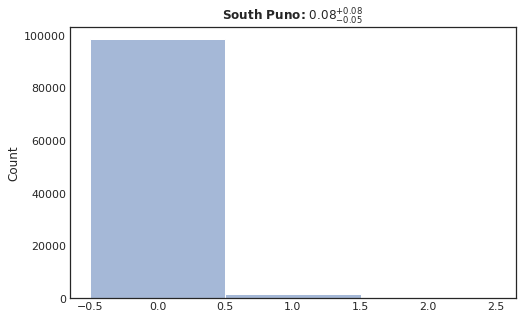

$95^{th}$ Percentile Range


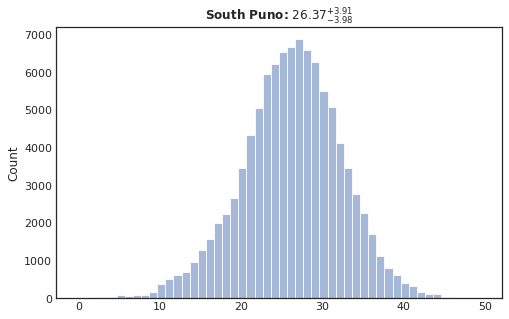

Interquartile Range


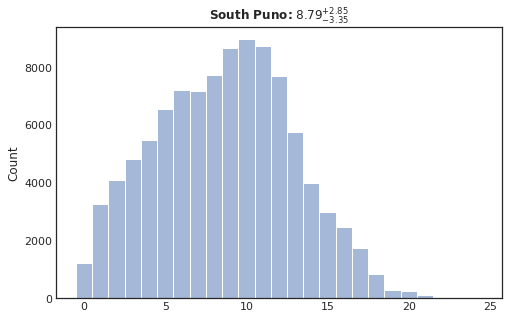

model metric is mean
The true value of y is: 0.9023238248653249 

the error is: 0.007620745576654727
Running burn-in...
Running production...
model metric is 95th percentile
The true value of y is: 0.5753214210271835 
 
the error is: 0.05898565728221925
Running burn-in...
Running production...
model metric is IQR
Running burn-in...
Running production...
Mean


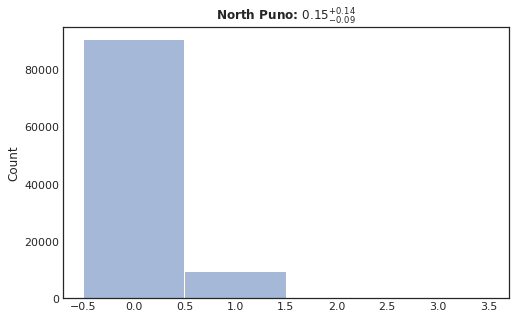

$95^{th}$ Percentile Range


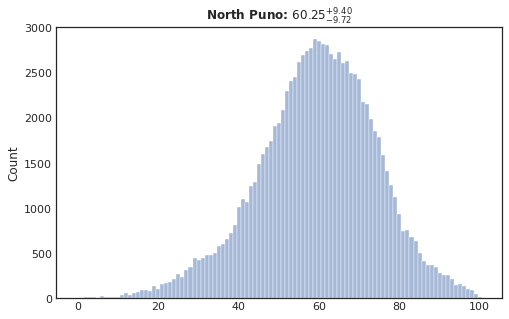

Interquartile Range


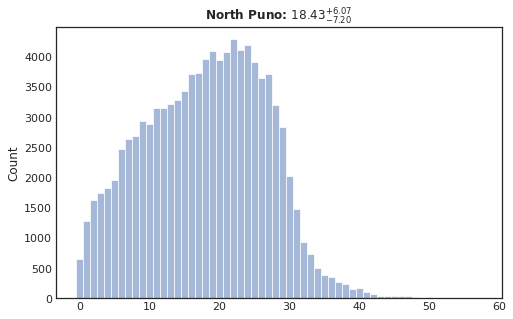

model metric is mean
The true value of y is: 0.9023238248653249 

the error is: 0.007690361235743288
Running burn-in...
Running production...
model metric is 95th percentile
The true value of y is: 0.5753214210271835 
 
the error is: 0.0583104835825757
Running burn-in...
Running production...
model metric is IQR
Running burn-in...
Running production...
Mean


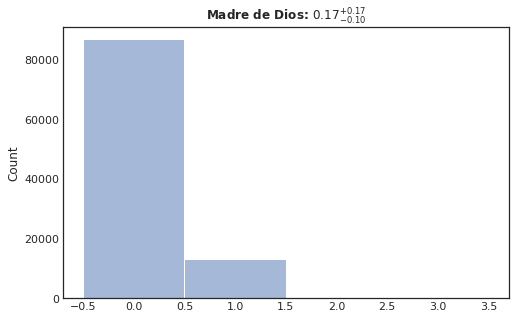

$95^{th}$ Percentile Range


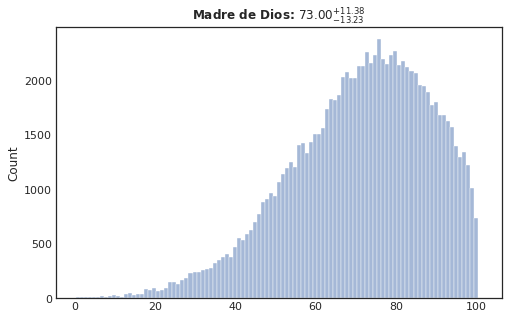

Interquartile Range


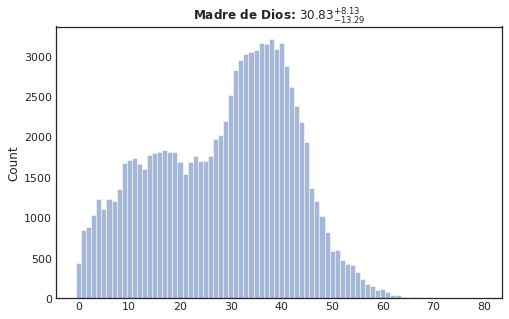

model metric is mean
The true value of y is: 0.9023238248653249 

the error is: 0.007806771180349413
Running burn-in...
Running production...
model metric is 95th percentile
The true value of y is: 0.5753214210271835 
 
the error is: 0.05752652866333071
Running burn-in...
Running production...
model metric is IQR
Running burn-in...
Running production...
Mean


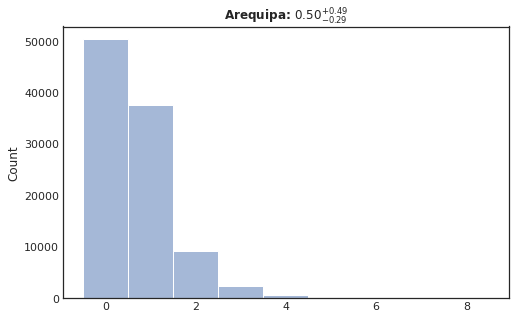

$95^{th}$ Percentile Range


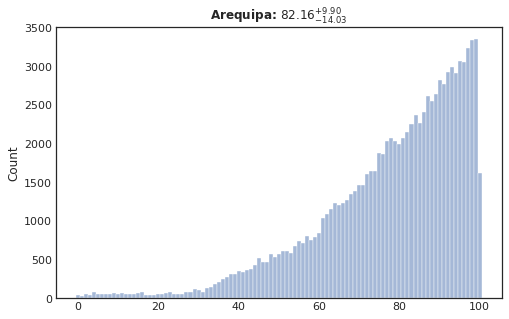

Interquartile Range


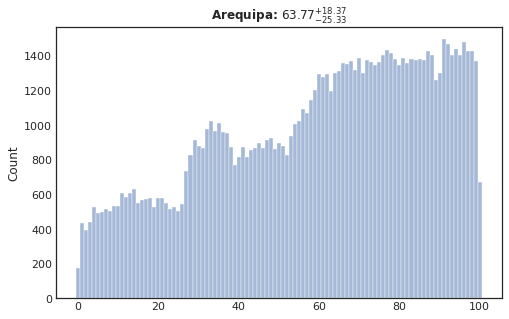

model metric is mean
The true value of y is: 0.9023238248653249 

the error is: 0.007648116430410919
Running burn-in...
Running production...
model metric is 95th percentile
The true value of y is: 0.5753214210271835 
 
the error is: 0.05893494561771902
Running burn-in...
Running production...
model metric is IQR
Running burn-in...
Running production...
Mean


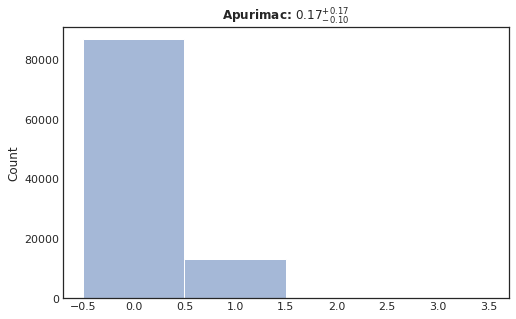

$95^{th}$ Percentile Range


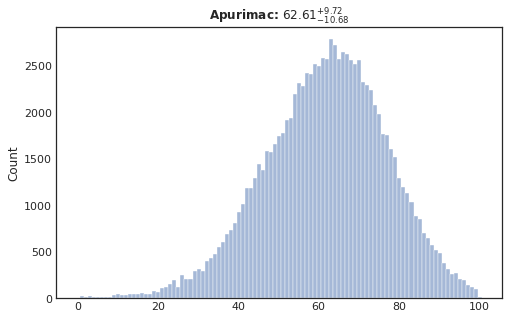

Interquartile Range


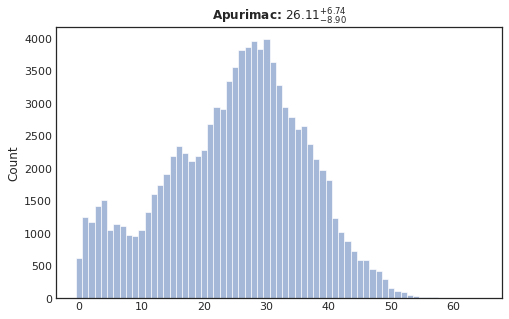

In [ ]:
grid_boxes=['spun','npun','mdd','aqp','apr']
for dep in grid_boxes:
    region=dep
    init = np.array([scalors[region][0]]) 
    metrics=['mean','95th','iqr']
    error=y_err
    ref_sites=0
    super_metric_dict={}
    for metric in metrics:
     #select the model based on the metric being used
        model = set_metric(metric)
        # initialize the constant teerms based on the right model
        ConstantTerm,region_sig=initEmcee(ref_sites,region)
        #run MCMC simulation
        sampler=run_simulation(ref_sites,metric,init)
        super_metric_dict[metric]= sampler
        #create corner plot
    for metric in metrics:
        if metric=='mean':
            met='Mean'
        elif metric=='95th':
            met= '$95^{th}$ Percentile Range'
        else:
            met= 'Interquartile Range'
        sampler=super_metric_dict[metric]
        #create corner plots
        corner_title= '''Corner'''+met
        print(met)
        plothist(sampler,region)

In [ ]:
obs_Hg0_d['value']

tstamp
2014-07-03    0.644308
2014-07-04    0.651114
2014-07-05    0.617688
2014-07-06    0.579989
2014-07-07    0.710160
                ...   
2015-06-29    0.859547
2015-06-30    0.849968
2015-07-01    1.048141
2015-07-02    0.895688
2015-07-03    1.009141
Name: value, Length: 366, dtype: float64

# Old Plots

Text(0.5, 0, 'Length of Chains')

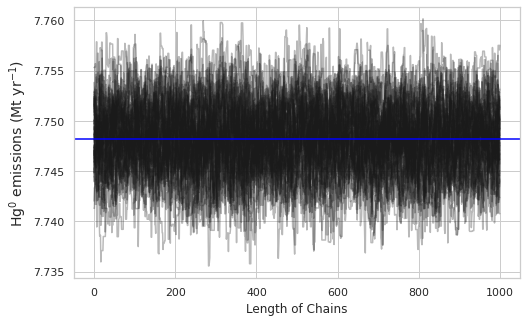

In [ ]:
#%% Plot chain results
fig= plt.figure( figsize=[8,5])
ax= fig.add_subplot(111)
res=plt.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.3)
SPuno_truval = scalors['spun'][0]
plt.axhline(SPuno_truval, color='blue')
ax.set_ylabel('Hg$^0$ emissions (Mt yr$^{-1}$)', fontsize = 14)
ax.set_xlabel('Length of Chains')

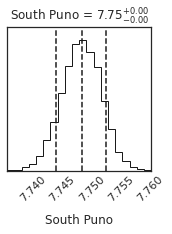

In [ ]:

#%% Plot corner plots to visualize 1D and 2D spreads between the parameters we are testing, and get some uncertainties on our paraemter estimations
labels = ['South Puno','North Puno','Madre de Dios','Arequipa','Apurimac']
samples = sampler.flatchain
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.10, 0.5, 0.90])
#fig.supxlabel("Corner Plots to Visualize 1D and 2D Spreads Between the Emission Amounts Being Tested\n",fontsize=16)

In [ ]:

#%% Plot corner plots to visualize 1D and 2D spreads between the parameters we are testing, and get some uncertainties on our paraemter estimations
print("""
labels = ['South Puno','North Puno','Madre de Dios','Arequipa','Apurimac']
samples = sampler.flatchain
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.10, 0.5, 0.90])
#fig.supxlabel("Corner Plots to Visualize 1D and 2D Spreads Between the Emission Amounts Being Tested\n",fontsize=16)""")


labels = ['South Puno','North Puno','Madre de Dios','Arequipa','Apurimac']
samples = sampler.flatchain
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.10, 0.5, 0.90])
#fig.supxlabel("Corner Plots to Visualize 1D and 2D Spreads Between the Emission Amounts Being Tested
",fontsize=16)


In [ ]:
samples.shape

(50000, 1)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

#fig = px.box(dfSamples, points="all")
#fig.show()


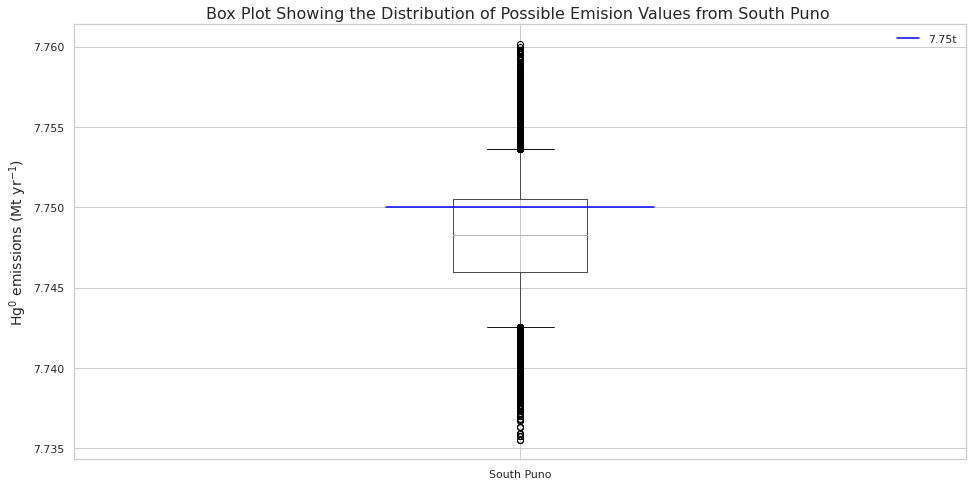

In [ ]:
dfSamples=pd.DataFrame(samples)
dfSamples.rename(columns = {0:'South Puno'}, inplace = True)
fig= plt.figure( figsize=[16,8])
ax= fig.add_subplot(111)
bpdict = dfSamples.boxplot(whis=[5, 95], return_type='dict')

ax.axhline(7.75,xmin=0.35, xmax=0.65,color = 'blue',label='7.75t')
# ax.axhline(11.66, xmin=0.20, xmax=0.40,color = 'orange',label='11.66t')
# ax.axhline(1.39, xmin=0.40, xmax=0.60,color = 'green',label='1.39t')
# ax.axhline(13.63, xmin=0.6, xmax=0.8,color = 'red',label='13.63t')
# ax.axhline(18.99, xmin=0.80, xmax=1,color = 'darkviolet',label='18.99t')
ax.legend()
ax.set_ylabel('Hg$^0$ emissions (Mt yr$^{-1}$)', fontsize = 14)
ax.set_title('Box Plot Showing the Distribution of Possible Emision Values from South Puno ', fontsize=16)
plt.show()


In [ ]:
print("""fig= plt.figure( figsize=[16,8])
ax= fig.add_subplot(111)
bpdict = dfSamples.boxplot(whis=[5, 95], return_type='dict')

ax.axhline(7.75,xmin=0, xmax=0.20,color = 'blue',label='7.75t')
ax.axhline(11.66, xmin=0.20, xmax=0.40,color = 'orange',label='11.66t')
ax.axhline(1.39, xmin=0.40, xmax=0.60,color = 'green',label='1.39t')
ax.axhline(13.63, xmin=0.6, xmax=0.8,color = 'red',label='13.63t')
ax.axhline(18.99, xmin=0.80, xmax=1,color = 'darkviolet',label='18.99t')
ax.legend()
ax.set_ylabel('[Hg$^0$] (ng m$^{-3}$)')
ax.set_title('Comparison of Emission Amount Distributions When the Mean is Used', fontsize=16)
plt.show()""")


fig= plt.figure( figsize=[16,8])
ax= fig.add_subplot(111)
bpdict = dfSamples.boxplot(whis=[5, 95], return_type='dict')

ax.axhline(7.75,xmin=0, xmax=0.20,color = 'blue',label='7.75t')
ax.axhline(11.66, xmin=0.20, xmax=0.40,color = 'orange',label='11.66t')
ax.axhline(1.39, xmin=0.40, xmax=0.60,color = 'green',label='1.39t')
ax.axhline(13.63, xmin=0.6, xmax=0.8,color = 'red',label='13.63t')
ax.axhline(18.99, xmin=0.80, xmax=1,color = 'darkviolet',label='18.99t')
ax.legend()
ax.set_ylabel('[Hg$^0$] (ng m$^{-3}$)')
ax.set_title('Comparison of Emission Amount Distributions When the Mean is Used', fontsize=16)
plt.show()


In [ ]:
dfSamples.median()

0    7.748256
dtype: float64

In [ ]:
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)',
          'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)']
y_data=[dfSamples[labels[0]],dfSamples[labels[1]],dfSamples[labels[2]],dfSamples[labels[3]],dfSamples[labels[4]]]

x_data = labels

fig = go.Figure()

for xd, yd, cls in zip(x_data, y_data, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            whiskerwidth=0.2,
            fillcolor=cls,
            line_width=1)
        )

fig.update_layout(
    title='Box Plots Showing Distributions of the Emissions from Each Region',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)

fig.show()

KeyError: 'South Puno'